# Data

In [ ]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
import re
from nltk.corpus import stopwords
from nltk import word_tokenize
import nltk
nltk.download('stopwords')
STOPWORDS = set(stopwords.words('english'))
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
import pandas as pd 
data=pd.read_csv("https://www.consumerfinance.gov/data-research/consumer-complaints/search/api/v1/?date_received_max=2021-05-20&date_received_min=2018-05-20&field=all&format=csv&no_aggs=true&size=1043275")

In [ ]:
data.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,07/30/19,"Credit reporting, credit repair services, or o...",Credit reporting,Improper use of your report,Reporting company used your report improperly,The following companies ran unauthorized credi...,None,"EQUIFAX, INC.",FL,322XX,None,Consent provided,Web,07/30/19,Closed with explanation,Yes,NaN,3324019
1,04/07/19,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",MA,None,None,Other,Web,04/07/19,Closed with explanation,Yes,NaN,3204485
2,06/14/19,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",AL,354XX,None,Consent not provided,Web,06/14/19,Closed with explanation,Yes,NaN,3274936
3,03/31/19,Credit card or prepaid card,General-purpose credit card or charge card,Fees or interest,Problem with fees,"On XX/XX/XXXX, I applied for a Citi XXXX Visa ...",Company has responded to the consumer and the ...,"CITIBANK, N.A.",CO,80215,None,Consent provided,Web,03/31/19,Closed with explanation,Yes,NaN,3197078
4,11/23/20,Debt collection,Other debt,Attempts to collect debt not owed,Debt is not yours,NaN,Company believes it acted appropriately as aut...,"Professional Debt Mediation, Inc.",None,None,None,NaN,Phone,11/23/20,Closed with explanation,Yes,NaN,3970396


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1051187 entries, 0 to 1051186
Data columns (total 18 columns):
 #   Column                        Non-Null Count    Dtype  
---  ------                        --------------    -----  
 0   Date received                 1051187 non-null  object 
 1   Product                       1051187 non-null  object 
 2   Sub-product                   1051187 non-null  object 
 3   Issue                         1051187 non-null  object 
 4   Sub-issue                     1051187 non-null  object 
 5   Consumer complaint narrative  426327 non-null   object 
 6   Company public response       1051187 non-null  object 
 7   Company                       1051187 non-null  object 
 8   State                         1051187 non-null  object 
 9   ZIP code                      1051187 non-null  object 
 10  Tags                          1051187 non-null  object 
 11  Consumer consent provided?    913605 non-null   object 
 12  Submitted via               

# Preprocessing

we only keep Product and Customer complaint narrative 

In [ ]:
data = data[["Product","Consumer complaint narrative"]]

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1051187 entries, 0 to 1051186
Data columns (total 2 columns):
 #   Column                        Non-Null Count    Dtype 
---  ------                        --------------    ----- 
 0   Product                       1051187 non-null  object
 1   Consumer complaint narrative  426327 non-null   object
dtypes: object(2)
memory usage: 16.0+ MB


In [ ]:
data.dropna(how="any",inplace=True,axis=0)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 426327 entries, 0 to 1051176
Data columns (total 2 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   Product                       426327 non-null  object
 1   Consumer complaint narrative  426327 non-null  object
dtypes: object(2)
memory usage: 9.8+ MB


In [ ]:
data.Product.value_counts()

Credit reporting, credit repair services, or other personal consumer reports    213837
Debt collection                                                                  74498
Credit card or prepaid card                                                      41699
Mortgage                                                                         33179
Checking or savings account                                                      24720
Money transfer, virtual currency, or money service                               11233
Student loan                                                                     10400
Vehicle loan or lease                                                             9923
Payday loan, title loan, or personal loan                                         6838
Name: Product, dtype: int64

In [ ]:
data.loc[data['Product'] == 'Student loan', 'Product'] = 'Payday loan, title loan, or personal loan'
data.loc[data['Product'] == 'Vehicle loan or lease', 'Product'] = 'Payday loan, title loan, or personal loan'
data.loc[data['Product'] == 'Mortgage', 'Product'] = 'Payday loan, title loan, or personal loan'




In [ ]:
data.Product.value_counts()

Credit reporting, credit repair services, or other personal consumer reports    213837
Debt collection                                                                  74498
Payday loan, title loan, or personal loan                                        60340
Credit card or prepaid card                                                      41699
Checking or savings account                                                      24720
Money transfer, virtual currency, or money service                               11233
Name: Product, dtype: int64

In [ ]:
data["Product"].replace({"Payday loan, title loan, or personal loan": "Loan"}, inplace=True)

In [ ]:
data.Product.value_counts()

Credit reporting, credit repair services, or other personal consumer reports    213837
Debt collection                                                                  74498
Loan                                                                             60340
Credit card or prepaid card                                                      41699
Checking or savings account                                                      24720
Money transfer, virtual currency, or money service                               11233
Name: Product, dtype: int64

In [ ]:
data.drop(data.index[(data["Product"] == "Credit card or prepaid card")],axis=0,inplace=True)

In [ ]:
data.Product.value_counts()

Credit reporting, credit repair services, or other personal consumer reports    213837
Debt collection                                                                  74498
Loan                                                                             60340
Checking or savings account                                                      24720
Money transfer, virtual currency, or money service                               11233
Name: Product, dtype: int64

In [ ]:
data = data.reset_index(drop=True)

In [ ]:
data

,Product,Consumer complaint narrative
0,"Credit reporting, credit repair services, or o...",The following companies ran unauthorized credi...
1,"Credit reporting, credit repair services, or o...",XXXX XXXX XXXX pulled my credit twice with in ...
2,"Credit reporting, credit repair services, or o...",To : Whom It May concern : I am writing to dis...
3,Debt collection,I'm not even sure what debt they are talking a...
4,Checking or savings account,Wells Fargo has sent me several general form l...
...,...,...
384623,Debt collection,"After an emergency room visit on XX/XX/18, I r..."
384624,"Credit reporting, credit repair services, or o...",I went to co sign for my partner e. car and wa...
384625,"Credit reporting, credit repair services, or o...","Originally, I sent a letter on XX/XX/2018 to X..."
384626,Debt collection,I purchased a XXXX XXXX from a person who show...


In [ ]:
#we define a function that displays the custumer complaint narrative to have a better idea of text in  order to know how to process it 
def complaint_product(indx,data):
  complaint = data['Consumer complaint narrative'][indx]
  product = data['Product'][indx]
  print(complaint)
  print('------------------------------')
  print("Product : ",product)

In [ ]:
complaint_product(238, data)

I have disputed the late payments on XXXX XXXX XXXX XXXX  for months. Experian refused to reverse the late payments. Not to mention they will not give me an explanation as to why they wont overturn or fix this erroneous inaccurate claim that has affected my credit score tremendously. CFPB please step up and fix this ASAP
------------------------------
Product :  Credit reporting, credit repair services, or other personal consumer reports


In [ ]:
import string 
#the complaint narrative contains some symboles (XXXXX) to hide the confidential informations such as amount of loan , number of credit card 
#we will delete them 
#we write a funcion to preprocess customer complaint narrative
def clean_text(text):
    '''Make text uppercase(this gonna be the output from speech recognition model which is in uppercase format), remove text in square brackets, remove punctuation, remove words containing numbers, remove stop words and Xs.'''
    text = text.upper()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('\n', '', text)
    text = text.replace('X', '')
    text = ' '.join(word for word in text.split() if word not in STOPWORDS)
    return text

In [ ]:
data['Consumer complaint narrative']=data['Consumer complaint narrative'].apply(clean_text)

In [ ]:
data

,Product,Consumer complaint narrative
0,"Credit reporting, credit repair services, or o...",PULLED MY CREDIT TWICE WITH IN A DAY PERIOD WI...
1,"Credit reporting, credit repair services, or o...",TO WHOM IT MAY CONCERN I AM WRITING TO DISPUTE...
2,Debt collection,IM NOT EVEN SURE WHAT DEBT THEY ARE TALKING AB...
3,Checking or savings account,WELLS FARGO HAS SENT ME SEVERAL GENERAL FORM L...
4,"Credit reporting, credit repair services, or o...",COMPANY HAS WROTE THE LOAN AMOUNT OFF AS A LOS...
...,...,...
382941,Checking or savings account,I WENT INTO THE AND BRANCH OF WELLS FARGO IN O...
382942,"Credit reporting, credit repair services, or o...",ORIGINALLY I SENT A LETTER ON TO DISPUTING A T...
382943,Debt collection,I PURCHASED A FROM A PERSON WHO SHOWED UP AT M...
382944,"Credit reporting, credit repair services, or o...",ON AN AGREEMENT WAS MADE BETWEEN KOHL S AND MY...


In [ ]:
complaint_product(238, data)

I HAVE DISPUTED THE LATE PAYMENTS ON FOR MONTHS EPERIAN REFUSED TO REVERSE THE LATE PAYMENTS NOT TO MENTION THEY WILL NOT GIVE ME AN EPLANATION AS TO WHY THEY WONT OVERTURN OR FI THIS ERRONEOUS INACCURATE CLAIM THAT HAS AFFECTED MY CREDIT SCORE TREMENDOUSLY CFPB PLEASE STEP UP AND FI THIS ASAP
------------------------------
Product :  Credit reporting, credit repair services, or other personal consumer reports


**Data Viz**

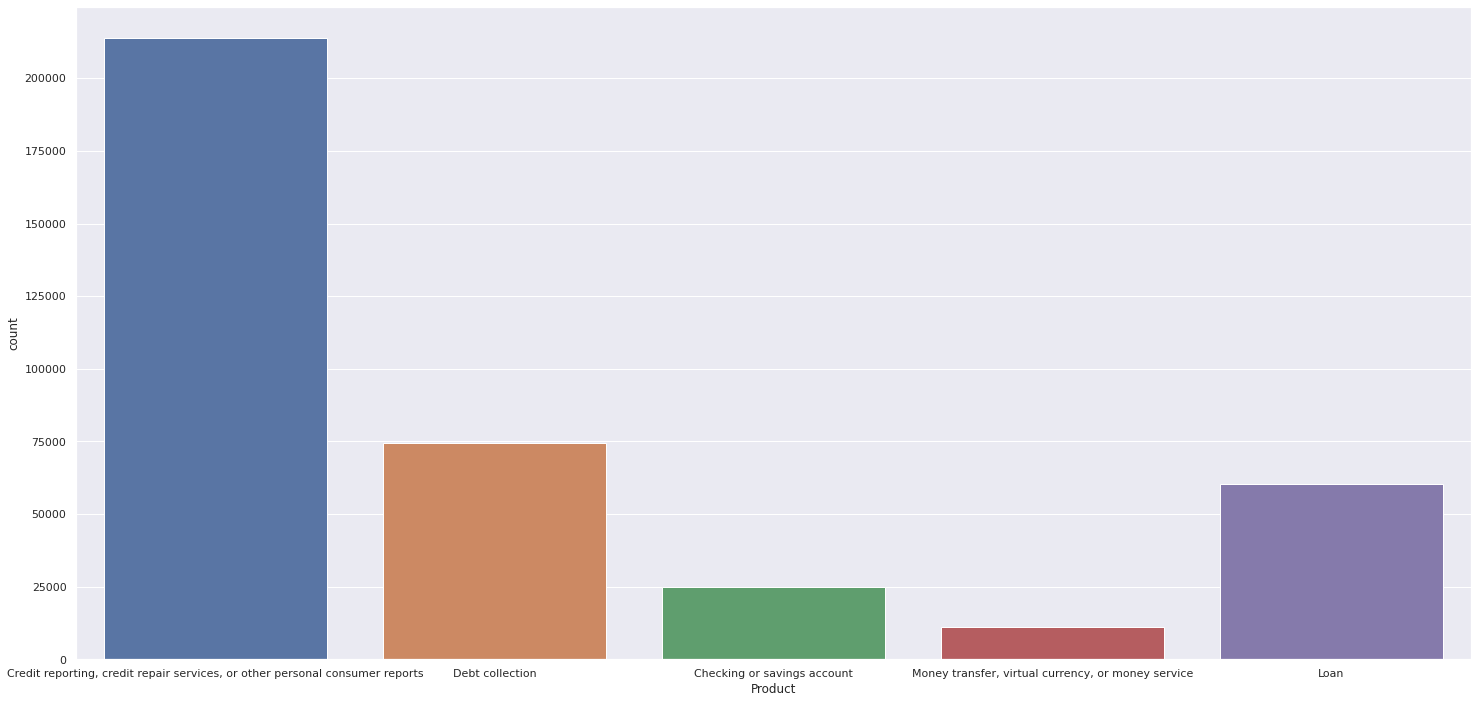

In [ ]:
import seaborn as sns
sns.set(rc={'figure.figsize':(25,12)})
sns.countplot(x="Product",data=data); 

As we can see, this dataset suffers from huge imbalanced data we will apply some data augmentation Techniques

# Data augmentation 

**Back Translation**

In [ ]:
pip install google_trans_new


In [ ]:
from google_trans_new import google_translator  
translator = google_translator(url_suffix="hk",timeout=1600)


In [ ]:
#Money transfer, virtual currency, or money service augemtation 
import time
def data_augmentation_money_transfer (data):
  newdata=data[data["Product"]=="Money transfer, virtual currency, or money service"]
  for x in newdata["Consumer complaint narrative"]:
    
    french_translation = translator.translate(x, lang_tgt='fr')
    time.sleep(2)
    english_translation = translator.translate(french_translation, lang_tgt='en')
    dict_1={"Product":"Money transfer, virtual currency, or money service","Consumer complaint narrative":[english_translation]}
    data=pd.concat([data,pd.DataFrame(dict_1)]) 
  return data

In [ ]:
import tensorflow as tf
tf.test.gpu_device_name() 

'/device:GPU:0'

In [ ]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm() 

  Created wheel for gputil: filename=GPUtil-1.4.0-cp37-none-any.whl size=7411 sha256=4035af947ee228f813365851142da8a9e0d312ecdafa55b1d6c66f73d007b6c3
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
Gen RAM Free: 12.3 GB  | Proc size: 935.1 MB
GPU RAM Free: 14887MB | Used: 222MB | Util   1% | Total 15109MB


In [ ]:
data=data_augmentation_money_transfer(data)

In [ ]:
data_credit=data[data["Product"]=="Credit reporting, credit repair services, or other personal consumer reports"]
new_data_credit=data_credit.sample(n=32000)
data_loan=data[data["Product"]=="Loan"]
new_data_loan=data_loan.sample(n=32000)
data_debt=data[data["Product"]=="Debt collection"]
new_data_debt=data_debt.sample(n=32000)
data_saving=data[data["Product"]=="Checking or savings account"]
new_data_saving=data_saving.sample(n=32000)
data=data[data["Product"]=="Money transfer, virtual currency, or money service"]
data=pd.concat([data,new_data_credit])
data=pd.concat([data,new_data_loan])
data=pd.concat([data,new_data_debt])
data=pd.concat([data,new_data_saving])


In [ ]:
data["Product"].value_counts()

Credit reporting, credit repair services, or other personal consumer reports    32000
Checking or savings account                                                     32000
Loan                                                                            32000
Debt collection                                                                 32000
Money transfer, virtual currency, or money service                              31886
Name: Product, dtype: int64

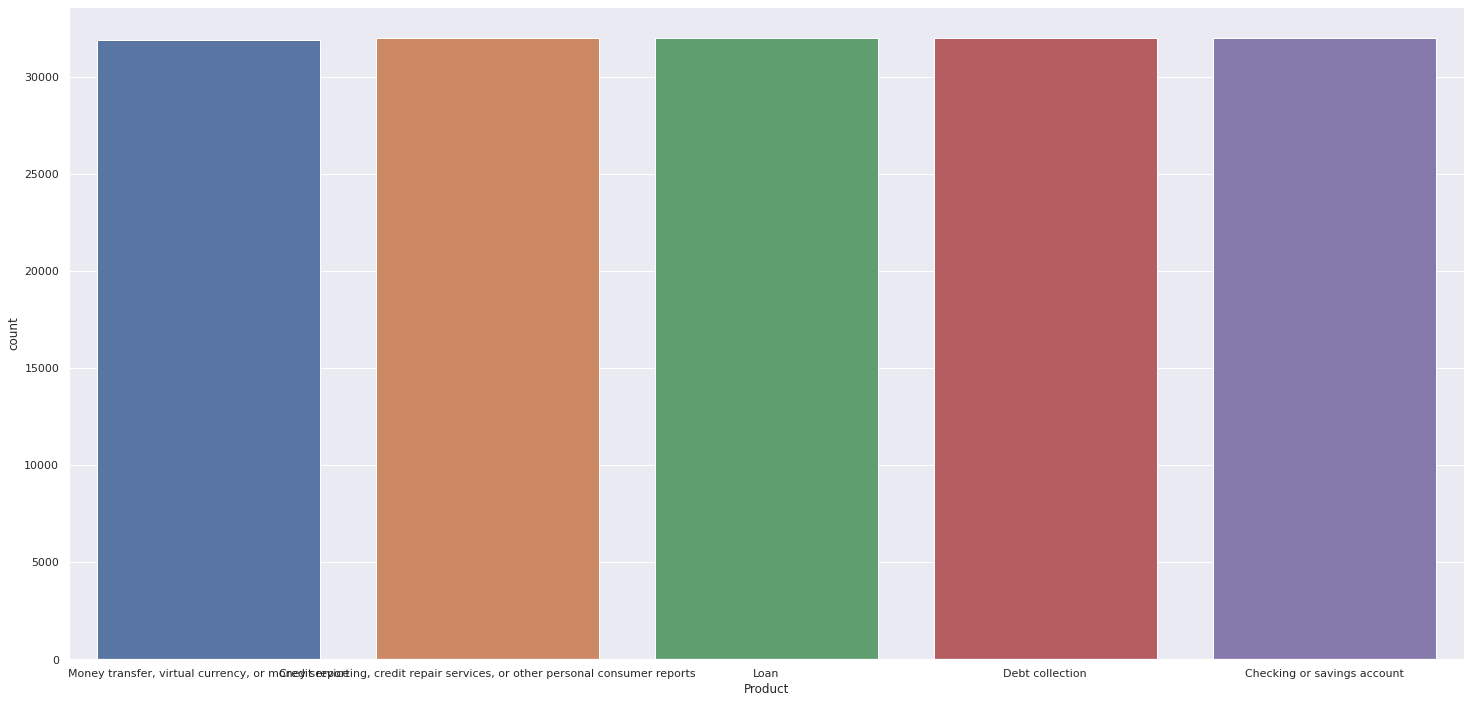

In [ ]:
import seaborn as sns
sns.set(rc={'figure.figsize':(25,12)})
sns.countplot(x="Product",data=data); 

**the data is  well balanced we can now begin the training**

#  Context Classifiction

In [ ]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# ech word in the embedding spece is a vector of dimentiality = 100 
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(data['Consumer complaint narrative'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 104035 unique tokens.


Corpus(104035)

In [ ]:
X = tokenizer.texts_to_sequences(data['Consumer complaint narrative'].values)#list of integers that contain the tokens mapped to each word in the text 


In [ ]:
len(X)

159886

In [ ]:
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH) #padding


In [ ]:
X

array([[   0,    0,    0, ...,  322,  180,  100],
       [   0,    0,    0, ...,   10,   92,  851],
       [   0,    0,    0, ...,  262,  239,  613],
       ...,
       [  15,   33,    5, ...,  226,   82, 1354],
       [   1,  134,   85, ...,    6,  386,   54],
       [4394, 2336,   26, ...,   18,   13, 2377]], dtype=int32)

In [ ]:
print('Shape of data tensor:', X.shape)

Shape of data tensor: (159886, 250)


In [ ]:
labels = list(pd.get_dummies(data['Product']).columns)
labels

['Checking or savings account',
 'Credit reporting, credit repair services, or other personal consumer reports',
 'Debt collection',
 'Loan',
 'Money transfer, virtual currency, or money service']

In [ ]:
Y = pd.get_dummies(data['Product']).values


In [ ]:
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (159886, 5)


In [ ]:

X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.2)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(127908, 250) (127908, 5)
(31978, 250) (31978, 5)


In [ ]:
model = Sequential()

#the embedding layer from keras (meme fonctionatilté que word2vec: mapps the word into a vector in the embedding space)
#note: word2vec is trained to extract the relation between words d'une facon general beacause it s trained on the wiki corpus
#while the embedding layer shows the relation between words in the context of this dataset (more specific we can say)
#not the same training algo(the keras embedding layer tries to index a table) 
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(9, activation='softmax'))
model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 250, 100)          5000000   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 250, 100)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               80400     
_________________________________________________________________
dense (Dense)                (None, 9)                 909       
Total params: 5,081,309
Trainable params: 5,081,309
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
epochs = 5
batch_size = 64
history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

In [ ]:
score=model.evaluate(X_test,Y_test)

print('Test set\n  Loss: {:0.2f}\n  Accuracy: {:0.2f}'.format(score[0],score[1]))

loss: 0.2408 - accuracy: 0.9253

In [ ]:
Y_pred = model.predict(X_test)

In [ ]:
Y_pred

array([[9.92766142e-01, 6.12234406e-04, 1.90342776e-03, 4.12620662e-04,
        4.30554757e-03],
       [9.97210205e-01, 3.52768868e-04, 2.20823567e-04, 2.90680386e-04,
        1.92549091e-03],
       [9.96968210e-01, 4.07065992e-04, 3.71939794e-04, 4.31063119e-04,
        1.82171387e-03],
       ...,
       [4.80249408e-04, 7.17526302e-03, 9.90594387e-01, 1.51085772e-03,
        2.39249799e-04],
       [4.45563055e-05, 1.25556090e-03, 9.97689009e-01, 1.00536004e-03,
        5.56531404e-06],
       [9.97490406e-01, 1.50972965e-05, 1.13954557e-04, 5.39939268e-04,
        1.84063020e-03]], dtype=float32)

In [ ]:
predicted_classes = np.argmax(Y_pred, axis=1)

In [ ]:
predicted_classes

array([0, 0, 0, ..., 2, 2, 0])

In [ ]:
expected_classes =np.argmax(Y_test, axis=1)

In [ ]:
Y_pred = model.predict(X_test)
Y_pred =np.argmax(Y_pred, axis=1)
Y_test =np.argmax(Y_test, axis=1)

In [ ]:
import pandas as pd
confusion_matrix=pd.crosstab(Y_test,Y_pred,rownames=["Actual"],colnames=["Predicted"])
print(confusion_matrix)
from sklearn.metrics import classification_report
print(classification_report(Y_test,Y_pred))

Predicted     0     1     2     3     4
Actual                                 
0          5768    41    52    82   375
1            58  5902   360   145    10
2            64   240  5893   146    16
3            75   166   209  5914    23
4           211    13    30    45  6140
              precision    recall  f1-score   support

           0       0.93      0.91      0.92      6318
           1       0.93      0.91      0.92      6475
           2       0.90      0.93      0.91      6359
           3       0.93      0.93      0.93      6387
           4       0.94      0.95      0.94      6439

    accuracy                           0.93     31978
   macro avg       0.93      0.93      0.93     31978
weighted avg       0.93      0.93      0.93     31978



#Save model

In [ ]:
import pickle

In [ ]:
model.save("intent_analysis_model.h5")

# Save Modules

In [ ]:
import pickle 
with open("tokenizer.pickle","wb") as f :
  pickle.dump(tokenizer,f)

In [ ]:
with open("labels.pickle","wb") as f :
  pickle.dump(labels,f)